In [1]:
#import packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import os
from shapely.geometry import Point,  MultiPolygon
import shapely.wkt
import seaborn as sns
from geopy.distance import geodesic
import networkx as nx
import hypernetx as hnx
import openpyxl

import torch
import torch.nn as nn
import torch.optim as optim

import dhg as dhg
from dhg.nn import UniGCNConv
from dhg.nn import UniSAGEConv
from dhg.nn import UniGATConv
from dhg.nn import UniGINConv
from node2vec import Node2Vec

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

 No module named 'igraph'. If you need to use hypernetx.algorithms.hypergraph_modularity, please install additional packages by running the following command: pip install .['all']


/home/melike/anaconda3/lib/python3.9/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [2]:
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)
plt.style.use('ggplot')

In [3]:
#import data sets
schools = pd.read_csv('/home/melike/UrbanComputing/Data/act_means.csv')
school_locations = pd.read_csv("/home/melike/UrbanComputing/Data/School_Locations.csv")
school_details = pd.read_csv("/home/melike/UrbanComputing/Data/school_details.csv")
schools_perc = pd.read_csv('/home/melike/UrbanComputing/Data/enrollment_perc.csv')

boundaries_fp='/home/melike/UrbanComputing/Data/geo_export.shp'
boundaries=gpd.read_file(boundaries_fp)


In [4]:
# Filter rows where the "Category Breakdown" column is equal to "Overall"
schools = schools[schools["Category Breakdown"] == "Overall"]

# Define a list of years to keep
years_to_keep = [2014, 2015, 2016, 2017]

# Filter rows where the "Year" column is in the list of years to keep
schools = schools[schools["Year"].isin(years_to_keep)]

# Define a list of columns to drop from the DataFrame
columns_to_drop = ['Network', 'Category Breakdown', "Grade", "Read", "Means_Math",
                   "Means_Science", "Means_English", "Numbers_Read", "Numbers_Math", "Numbers_Science", "Numbers_English"]

# Drop the specified columns from the DataFrame
schools = schools.drop(columns=columns_to_drop)


In [5]:
# Extracting latitude and longitude from the 'the_geom' column and converting them to float
school_locations[['Long', 'Lat']] = school_locations['the_geom'].str.extract(r'POINT \(([-\d.]+) ([-\d.]+)\)').astype(float)

# Renaming the 'School ID' column to 'School_ID' for consistency
schools = schools.rename(columns={'School ID': 'School_ID'})

# Merging the 'schools' DataFrame with 'school_locations' on the 'School_ID' column using inner join
schools = pd.merge(schools, school_locations, on='School_ID', how='inner')

# Dropping specified columns ('Short_Name', 'Address', 'Grade_Cat') from the 'schools' DataFrame
columns_to_drop2 = ['Short_Name', 'Address', "Grade_Cat"]
schools = schools.drop(columns=columns_to_drop2)

# Dropping rows with missing values in specified columns
columns_to_check_missing = ['School Name', 'Means_Composite', 'School_ID', 'Category']
schools = schools.dropna(subset=columns_to_check_missing)

# Merging the 'schools' DataFrame with 'school_details' on the columns 'School_ID' and 'Year' using left join
schools = pd.merge(schools, school_details, on=['School_ID', "Year"], how='left')

In [6]:
econ15 = pd.read_csv('/home/melike/UrbanComputing/Data/econ15.csv')
econ16 = pd.read_csv("/home/melike/UrbanComputing/Data/econ16.csv")
econ17 = pd.read_csv("/home/melike/UrbanComputing/Data/econ17.csv")
econ18 = pd.read_csv("/home/melike/UrbanComputing/Data/econ18.csv")

regions = pd.read_csv("/home/melike/UrbanComputing/Data/regions.csv")

In [7]:
# Fill missing values in the 'Attainment' column with the mean value of the column
schools['Attainment'] = schools['Attainment'].fillna(schools['Attainment'].mean())

# Fill missing values in the '4_Year_Graduation_Rate' column with the mean value of the column
schools['4_Year_Graduation_Rate'] = schools['4_Year_Graduation_Rate'].fillna(schools['4_Year_Graduation_Rate'].mean())

# Fill missing values in the 'Attendance_Rate' column with the mean value of the column
schools['Attendance_Rate'] = schools['Attendance_Rate'].fillna(schools['Attendance_Rate'].mean())

In [8]:
# Drop the column "School Name" from the DataFrame 'schools_perc'
schools_perc = schools_perc.drop(["School Name"], axis=1)

# Merge the 'schools' DataFrame with the modified 'schools_perc' DataFrame
# The merge is based on the columns 'School_ID' and 'Year', using a left join
schools = pd.merge(schools, schools_perc, on=['School_ID', "Year"], how='left')


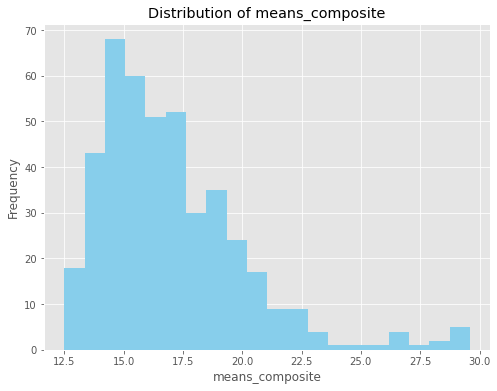

In [9]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(schools['Means_Composite'], bins=20, color='skyblue')  # Adjust the number of bins as needed
plt.title('Distribution of means_composite')
plt.xlabel('means_composite')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [10]:
schools = schools.dropna()

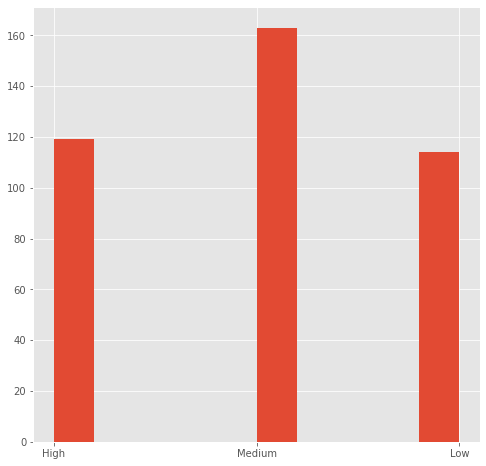

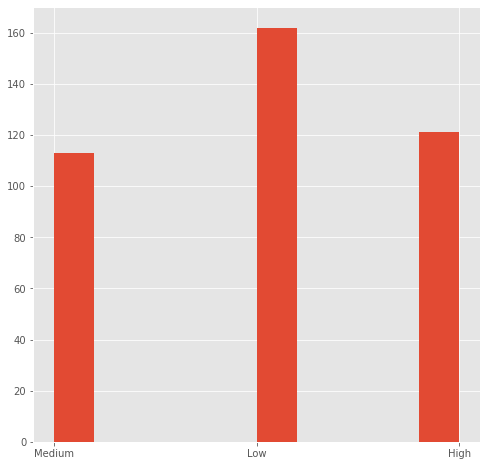

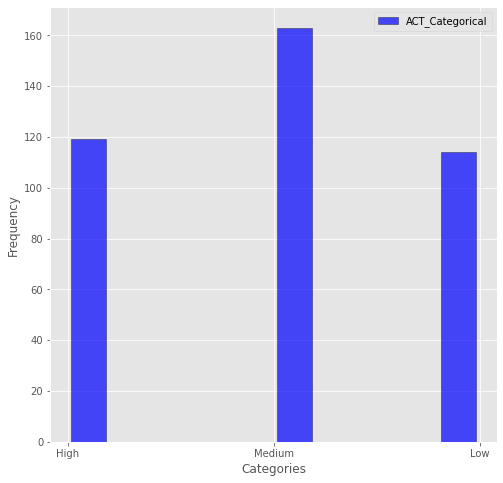

In [11]:
# Function to categorize a score into Low, Medium, or High
def categorize_score(score):
    if score < 15:
        return "Low"
    elif 15 <= score < 18:
        return "Medium"
    else:
        return "High"

# Function to categorize a percentage into Low, Medium, or High
def categorize_percentage(score):
    if score < 0.50:
        return "Low"
    elif 0.50 <= score < 0.67:
        return "Medium"
    else:
        return "High"

# Applying the categorize_score function to the 'Means_Composite' column and creating a new column 'ACT_Categorical'
schools['ACT_Categorical'] = schools['Means_Composite'].apply(categorize_score)

# Applying the categorize_percentage function to the 'Percentage' column and creating a new column 'Percentage_Categorical'
schools["Percentage_Categorical"] = schools['Percentage'].apply(categorize_percentage)


#schools['ACT_Categorical'] = pd.cut(schools['Means_Composite'], bins=3, labels=['Low', 'Medium', "High"])
#schools['Percentage_Categorical'] = pd.cut(schools['Percentage'], bins=3, labels=['Low', 'Medium', "High"])


plt.hist(schools['ACT_Categorical'])
plt.show()
plt.hist(schools['Percentage_Categorical'])
plt.show()

plt.hist(schools['ACT_Categorical'], bins='auto', alpha=0.7, rwidth=0.85, color='blue', edgecolor='black')

# Add legend
plt.legend(['ACT_Categorical'])

plt.xlabel('Categories')
plt.ylabel('Frequency')

# Show the plot
plt.show()

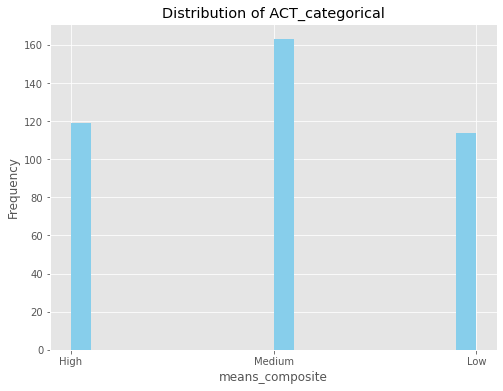

In [12]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.hist(schools['ACT_Categorical'], bins=20, color='skyblue')  # Adjust the number of bins as needed
plt.title('Distribution of ACT_categorical')
plt.xlabel('means_composite')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [13]:
precincts = {}
for index, row in regions.iterrows():
    precincts[row['AREA_NUMBE']] = shapely.wkt.loads(row['the_geom'])

# Initialize arrays to store precinct information, latitude, and longitude for each school
pos = 0
prec = np.ndarray((schools.shape[0],))
date = np.ndarray((schools.shape[0],)).astype(str)

# Iterate through each school in the 'schools' DataFrame
for index, row in schools.iterrows():
    # Create a Point object for the school's location using longitude and latitude
    poo = Point(row['Long'], row['Lat'])
    
    # Iterate through precincts to find the one in which the school is located
    for key, val in precincts.items():
        if poo.within(val):  # Check if the school is within the precinct's geometry
            prec[pos] = key  # Store the precinct identifier
            break
    
    pos = pos + 1

# Add a new column 'Precincts' to the 'schools' DataFrame with the precinct information
schools['Precincts'] = prec.astype(int)

# Filter out schools with invalid precinct information (precincts with negative values)
schools = schools[schools['Precincts'] >= 0]

In [14]:
precinct_names = {}

for index, row in regions.iterrows():
    precinct_names[row['AREA_NUMBE']] = row['COMMUNITY'] 

# Apply the mapping to the 'Precincts' column in the schools dataframe
schools['Community'] = schools['Precincts'].map(precinct_names)

In [15]:
df_list = [econ15, econ16, econ17]

# Iterate over each DataFrame in the list
for df in df_list:
    # Calculate the total population for each row by summing up specific demographic columns
    df['Total_Population'] = df[["WHITE","HISP","BLACK","ASIAN","OTHER"]].sum(axis=1)

    # List of demographic columns
    demographic_columns = ["WHITE","HISP","BLACK","ASIAN","OTHER"]

    # Normalize each demographic column by dividing it by the 'Total_Population'
    for col in demographic_columns:
        df[col] = df[col] / df['Total_Population']

In [16]:
df_list = [econ15, econ16, econ17]

for df in df_list:
    df['Total_Population'] = df[["UND19", "A20_34", "A35_49", "A50_64", "A65_79", "OV80"]].sum(axis=1)

    demographic_columns = ["UND19", "A20_34", "A35_49", "A50_64", "A65_79","OV80"]
    for col in demographic_columns:
        df[col] = df[col] / df['Total_Population']


In [17]:
df_list = [econ15, econ16, econ17]

for df in df_list:
    df['Total_Population'] = df[["IN_LBFRC", "EMP", "UNEMP", "NOT_IN_LBFRC"]].sum(axis=1)

    demographic_columns = ["IN_LBFRC", "EMP", "UNEMP", "NOT_IN_LBFRC"]
    for col in demographic_columns:
        df[col] = df[col] / df['Total_Population']


In [18]:
df_list = [econ15, econ16, econ17]

for df in df_list:
    df['Total_Population'] = df[["INC_LT_25K", "INC_25_50K", "INC_50_75K", "INC_75_100K", "INC_100_150K", "INC_GT_150"]].sum(axis=1)

    demographic_columns = ["INC_LT_25K", "INC_25_50K", "INC_50_75K", "INC_75_100K", "INC_100_150K", "INC_GT_150"]
    for col in demographic_columns:
        df[col] = df[col] / df['Total_Population']


In [19]:
econ15 = econ15.drop(["A65_79","OV80","MED_AGE", "MED_HV",	"MEDINC",	"TOT_POP", "TOT_HH", "MED_ROOMS", 'Total_Population'], axis=1)
econ16 = econ16.drop(["A65_79","OV80","MED_AGE", "MED_HV",	"MEDINC",	"TOT_POP", "TOT_HH", "MED_ROOMS", 'Total_Population'], axis=1)
econ17 = econ17.drop(["A65_79","OV80","MED_AGE", "MED_HV",	"MEDINC",	"TOT_POP", "TOT_HH", "MED_ROOMS", 'Total_Population'], axis=1)

In [20]:
econ15 = econ15.rename(columns={'GEOG': 'Community'})
econ16 = econ16.rename(columns={'GEOG': 'Community'})
econ17 = econ17.rename(columns={'GEOG': 'Community'})

schools['Community'] = schools['Community'].str.lower()
econ15['Community'] = econ15['Community'].str.lower()
econ16['Community'] = econ16['Community'].str.lower()
econ17['Community'] = econ17['Community'].str.lower()

#merged_df_15 = pd.merge(schools[schools['Year'] == 2014], econ15, on='Community', how='left')

#merged_df_16 = pd.merge(schools[schools['Year'] == 2015], econ16, on='Community', how='left')

#merged_df_17 = pd.merge(schools[schools['Year'] == 2016], econ17, on='Community', how='left')
#schools = pd.concat([merged_df_15, merged_df_16, merged_df_17], ignore_index=True)

merged_df_15 = pd.merge(schools[schools['Year'] == 2015], econ15, on='Community', how='left')
merged_df_16 = pd.merge(schools[schools['Year'] == 2016], econ16, on='Community', how='left')
schools = pd.concat([merged_df_15, merged_df_16], ignore_index=True)



In [21]:
public_health_data = pd.read_csv('/home/melike/UrbanComputing/Data/public_health_stats.csv')

In [22]:
# Convert the 'Community' column in the 'schools' DataFrame to lowercase
schools['Community'] = schools['Community'].str.lower()

# Rename the 'Community Area Name' column to 'Community' in the 'public_health_data' DataFrame
public_health_data = public_health_data.rename(columns={'Community Area Name': 'Community'})

# Convert the 'Community' column in the 'public_health_data' DataFrame to lowercase
public_health_data['Community'] = public_health_data['Community'].str.lower()

# Select specific columns from the 'public_health_data' DataFrame
public_health_data = public_health_data[["Community", "Teen Birth Rate", 'Assault (Homicide)', 'Below Poverty Level', 'Crowded Housing', 'Per Capita Income' ,'Unemployment']]

# Merge the 'schools' DataFrame with the 'public_health_data' DataFrame based on the 'Community' column, using a left join
schools = pd.merge(schools, public_health_data, on='Community', how='left')


In [23]:
schools = schools.dropna()

In [24]:
crimes = pd.read_csv("/home/melike/UrbanComputing/Data/Crimes2014_2020.csv")

# Selecting specific columns from the 'crimes' DataFrame
crimes = crimes[['Date', 'Block', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'Year', 'Latitude', 'Longitude', 'Location']]

# Defining a tuple 'types' containing specific crime types
types = "ARSON", "HOMICIDE", "OFFENSE INVOLVING CHILDREN","ROBBERY"

# Filtering rows in the 'crimes' DataFrame based on the 'Primary Type' column
crimes = crimes[crimes["Primary Type"].isin(types)]

# Renaming columns 'Latitude' to 'Lat' and 'Longitude' to 'Long'
crimes = crimes.rename(columns={'Latitude': 'Lat', "Longitude": "Long"})

# Dropping rows with missing values in columns 'Year', 'Lat', and 'Long'
crimes = crimes.dropna(subset=["Year", "Lat", "Long"])


In [25]:
# Convert latitude and longitude columns of schools and crimes dataframes to Point geometries
geometry_schools = [Point(xy) for xy in zip(schools['Long'], schools['Lat'])]
gdf_schools = gpd.GeoDataFrame(schools, geometry=geometry_schools)

geometry_crimes = [Point(xy) for xy in zip(crimes['Long'], crimes['Lat'])]
gdf_crimes = gpd.GeoDataFrame(crimes, geometry=geometry_crimes)

# Create a buffer of 2 km around schools
buffered_schools = gdf_schools.copy()
buffered_schools['geometry'] = gdf_schools.buffer(0.018)  # 1 degree is approximately 111 km

# Perform spatial join to find crimes (specifically robberies) within 2 km of each school
robbery_within_2km = gpd.sjoin(
    buffered_schools,
    gdf_crimes[gdf_crimes['Primary Type'] == 'ROBBERY'][['geometry', 'Year']],
    how='left',
    op='contains'
)

# Group by school and year to get the count of robberies within 2 km
robbery_count_by_school_year = (
    robbery_within_2km.groupby(['School_ID', 'Year_right'])['geometry']
    .count()
    .reset_index()
    .rename(columns={'geometry': 'Robbery_Count'})
)

# Rename the 'Year_right' column to 'Year' for consistency
robbery_count_by_school_year.rename(columns={'Year_right': 'Year'}, inplace=True)

# Merge the robbery count back into the original schools dataframe
schools = pd.merge(schools, robbery_count_by_school_year, on=['School_ID', "Year"], how='left')


/home/melike/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [26]:
# Perform spatial join between buffered schools and crime data for arson incidents
arson_within_2km = gpd.sjoin(
    buffered_schools,
    gdf_crimes[gdf_crimes['Primary Type'] == 'ARSON'][['geometry', 'Year']],
    how='left',
    op='contains'
)

# Group by School_ID and Year to count the number of arson incidents within 2km of each school
arson_count_by_school_year = (
    arson_within_2km.groupby(['School_ID', 'Year_right'])['geometry']
    .count()
    .reset_index()
    .rename(columns={'geometry': 'Arson_Count'})
)

# Rename the 'Year_right' column to 'Year'
arson_count_by_school_year.rename(columns={'Year_right': 'Year'}, inplace=True)

# Merge the arson count data with the schools data based on School_ID and Year
schools = pd.merge(schools, arson_count_by_school_year, on=['School_ID', "Year"], how='left')

/home/melike/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [27]:
# Spatial join between buffered schools and crimes within 2km, filtering for HOMICIDE crimes
homicide_within_2km = gpd.sjoin(
    buffered_schools,
    gdf_crimes[gdf_crimes['Primary Type'] == 'HOMICIDE'][['geometry', 'Year']],
    how='left',
    op='contains'
)

# Counting homicides grouped by School_ID and school year
homicide_count_by_school_year = (
    homicide_within_2km.groupby(['School_ID', 'Year_right'])['geometry']
    .count()
    .reset_index()
    .rename(columns={'geometry': 'Homicide_Count'})
)

# Renaming the 'Year_right' column to 'Year' for clarity
homicide_count_by_school_year.rename(columns={'Year_right': 'Year'}, inplace=True)

# Merging the homicide count with the original schools dataframe
schools = pd.merge(schools, homicide_count_by_school_year, on=['School_ID', "Year"], how='left')


/home/melike/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [28]:
# Perform a spatial join between buffered_schools and crimes within 2km having the primary type 'OFFENSE INVOLVING CHILDREN'
offense_within_2km = gpd.sjoin(
    buffered_schools,
    gdf_crimes[gdf_crimes['Primary Type'] == 'OFFENSE INVOLVING CHILDREN'][['geometry', 'Year']],
    how='left',
    op='contains'
)

# Group offenses within 2km by School_ID and Year, count the occurrences, and reset the index
offense_count_by_school_year = (
    offense_within_2km.groupby(['School_ID', 'Year_right'])['geometry']
    .count()
    .reset_index()
    .rename(columns={'geometry': 'Offense_Count'})
)

# Rename the 'Year_right' column to 'Year'
offense_count_by_school_year.rename(columns={'Year_right': 'Year'}, inplace=True)

# Merge the offense counts with the schools DataFrame based on School_ID and Year
schools = pd.merge(schools, offense_count_by_school_year, on=['School_ID', "Year"], how='left')


/home/melike/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


/home/melike/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/home/melike/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


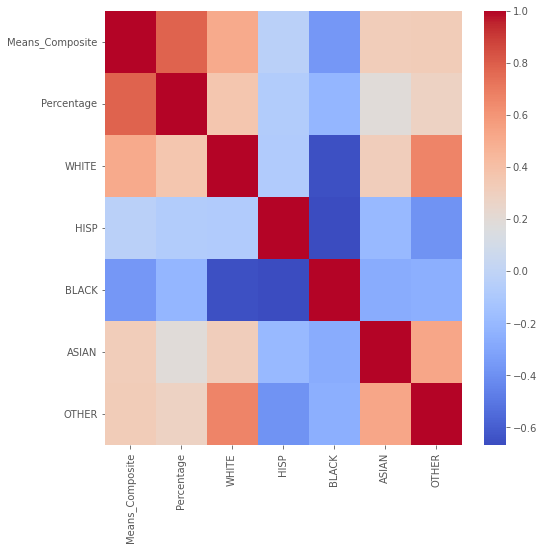

/home/melike/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/home/melike/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


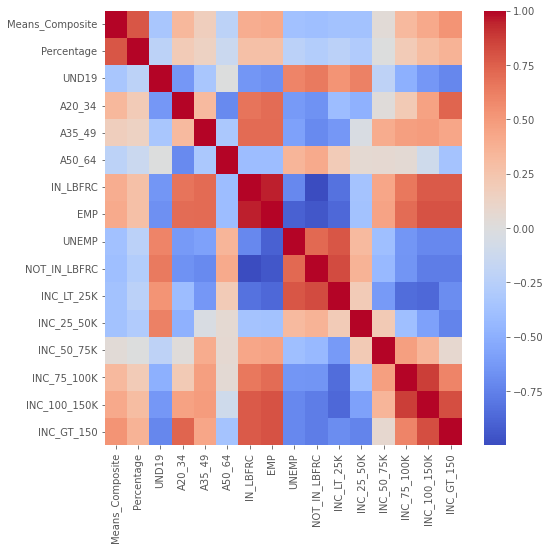

/home/melike/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:302: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/home/melike/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:312: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


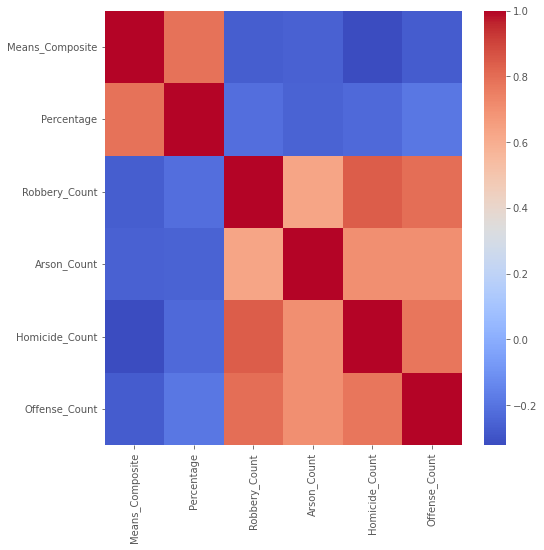

In [29]:
numeric_df = schools.select_dtypes(include='number')  # Select only numeric columns

numeric_df1= numeric_df[['Means_Composite', 'Percentage', 'WHITE', 'HISP', 'BLACK', 'ASIAN', 'OTHER']]

correlation_matrix1 = numeric_df1.corr()

# Generate a heatmap without numbers
sns.heatmap(correlation_matrix1, cmap='coolwarm', annot=False)
plt.show()

numeric_df2= numeric_df[[ 'Means_Composite', 'Percentage', 'UND19',
       'A20_34', 'A35_49', 'A50_64', 'IN_LBFRC', 'EMP',
       'UNEMP', 'NOT_IN_LBFRC', 'INC_LT_25K', 'INC_25_50K', 'INC_50_75K',
       'INC_75_100K', 'INC_100_150K', 'INC_GT_150',
       ]]

correlation_matrix2 = numeric_df2.corr()

# Generate a heatmap without numbers
sns.heatmap(correlation_matrix2, cmap='coolwarm', annot=False)
plt.show()

numeric_df3= numeric_df[['Means_Composite','Percentage', "Robbery_Count", "Arson_Count", "Homicide_Count",
                         "Offense_Count"]]

correlation_matrix3 = numeric_df3.corr()

sns.heatmap(correlation_matrix3, cmap='coolwarm', annot=False)
plt.show()

In [30]:
schools['Arson_Count'] = schools['Arson_Count'].fillna(0)
schools['Homicide_Count'] = schools['Homicide_Count'].fillna(0)

In [31]:
## will try sth

parks = gpd.read_file("/home/melike/UrbanComputing/Data/parks.csv")  ## parks and facilities

columns_to_drop3 = ['OBJECTID_1', "GISOBJID","geometry"]
parks = parks.drop(columns=columns_to_drop3)
parks = parks.rename(columns={'X_COORD': 'Long', 'Y_COORD': 'Lat'})

facility_types = ["BASEBALL SR", "BASKETBALL COURT", "POOL (INDOOR)", "POOL (OUTDOOR)"]

parks = parks[parks["FACILITY_N"].isin(facility_types)]

In [32]:
# Create GeoDataFrame for schools
geometry_schools = [Point(xy) for xy in zip(schools['Long'], schools['Lat'])]
gdf_schools = gpd.GeoDataFrame(schools, geometry=geometry_schools)

# Create GeoDataFrame for parks
geometry_parks = [Point(xy) for xy in zip(parks['Long'], parks['Lat'])]
gdf_parks = gpd.GeoDataFrame(parks, geometry=geometry_parks)

# Buffer schools by 1 km
buffered_schools = gdf_schools.copy()
buffered_schools['geometry'] = gdf_schools.buffer(0.009)  # 1 degree is approximately 111 km

# Find parks within the buffered area of each school
parks_within_2km = gpd.sjoin(buffered_schools, gdf_parks, how='left', op='contains')

# Count the number of parks within 2 km for each school
parks_count_by_school = parks_within_2km.groupby('School_ID')['PARK_NO'].count().reset_index()

# Merge the parks count back to the original schools DataFrame
schools = pd.merge(schools, parks_count_by_school, on='School_ID', how='left')  # facilities in parks


/home/melike/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [33]:
libraries = pd.read_csv("/home/melike/UrbanComputing/Data/libraries.csv")

# Function to convert string location to Point
def string_to_points(point):
    # Remove brackets from the location string
    point = point.replace("(", "")
    point = point.replace(")", "")

    # Parse the location string
    loc = point.split(',')

    # Returns a Point object
    return Point(float(loc[1]), float(loc[0]))

# Apply the string_to_points function to create a 'geometry' column
libraries['geometry'] = libraries['LOCATION'].apply(string_to_points)

# Define a function to extract latitude and longitude from the 'LOCATION' column
def extract_lat_lon(location_str):
    location_str = location_str.strip('()')
    lat, lon = location_str.split(', ')
    return float(lat), float(lon)

# Apply the extract_lat_lon function to create 'LATITUDE' and 'LONGITUDE' columns
libraries[['LATITUDE', 'LONGITUDE']] = libraries['LOCATION'].apply(extract_lat_lon).apply(pd.Series)

# Create a dictionary of precincts
precincts = {}
for index, row in regions.iterrows():
    precincts[row['AREA_NUMBE']] = shapely.wkt.loads(row['the_geom'])

# Initialize arrays to store precinct information
pos = 0
prec = np.ndarray((libraries.shape[0],))
date = np.ndarray((libraries.shape[0],)).astype(str)

# Loop through libraries DataFrame
for index, row in libraries.iterrows():
    # Create a Point object for each library
    poo = Point(row['LONGITUDE'], row['LATITUDE'])  
    # Check if the library is within any precinct
    for key, val in precincts.items():
        if poo.within(val):
            prec[pos] = key
            break
    pos = pos + 1

# Add 'Precincts' column to the libraries DataFrame
libraries['Precincts'] = prec.astype(int)

# Filter out rows where 'Precincts' is less than 0
libraries = libraries[libraries['Precincts'] >= 0]

# Rename 'LONGITUDE' and 'LATITUDE' columns to 'Long' and 'Lat'
libraries = libraries.rename(columns={'LONGITUDE': 'Long', 'LATITUDE': 'Lat'})

# Create Point geometries for schools and libraries
geometry_schools = [Point(xy) for xy in zip(schools['Long'], schools['Lat'])]
geometry_libraries = [Point(xy) for xy in zip(libraries['Long'], libraries['Lat'])]

# Create GeoDataFrames for schools and libraries
gdf_schools = gpd.GeoDataFrame(schools, geometry=geometry_schools)
gdf_libraries = gpd.GeoDataFrame(libraries, geometry=geometry_libraries)

# Buffer schools by 2 km
buffered_schools = gdf_schools.copy()
buffered_schools['geometry'] = gdf_schools.buffer(0.018)  # 1 degree is approximately 111 km

# Perform a spatial join to find libraries within 2 km of schools
libraries_within_2km = gpd.sjoin(buffered_schools, gdf_libraries, how='left', op='contains')

# Count the number of libraries within 2 km for each school
libraries_count_by_school = libraries_within_2km.groupby('School_ID')['NAME '].count().reset_index()

# Merge the count back into the schools DataFrame
schools = pd.merge(schools, libraries_count_by_school, on='School_ID', how='left')
schools = schools.rename(columns={'NAME ': 'LIB_NO'})


/home/melike/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score


# Features and Target
X = schools.drop(['School Name', 'School_ID', 'Category','Year','Means_Composite',
                  'Numbers_Composite', 'the_geom', 'Lat', 'Long','Precincts', 'Community',
                  "ACT_Categorical", "Percentage_Categorical", 
                  # 'Percentage', 
                  ], axis=1)  # Dropping non-numeric and target columns
y = schools['ACT_Categorical']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' is just an example, you can choose other options

print(f"Accuracy of the classifier: {accuracy:.4f}")
print(f"F1 score of the classifier: {f1:.4f}")

/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy of the classifier: 0.8824
F1 score of the classifier: 0.8804


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [35]:
#decision tree classifier
from sklearn.tree import DecisionTreeClassifier

model_original = DecisionTreeClassifier()

model_original.fit(X_train, y_train)

y_pred_original = model_original.predict(X_test)

accuracy_original = accuracy_score(y_test, y_pred_original)

f1 = f1_score(y_test, y_pred_original, average='weighted')  # 'weighted' is just an example, you can choose other options

print(f"Accuracy of the classifier: {accuracy:.4f}")
print(f"F1 score of the classifier: {f1:.4f}")

Accuracy of the classifier: 0.8824
F1 score of the classifier: 0.7793


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [36]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)

xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_encoded)

y_pred_xgb = xgb_model.predict(X_test)

y_pred_decoded = label_encoder.inverse_transform(y_pred_xgb)

accuracy = accuracy_score(y_test, y_pred_decoded)
f1 = f1_score(y_test, y_pred_decoded, average='weighted')  # 'weighted' is just an example, you can choose other options

print(f"Accuracy of the classifier: {accuracy:.4f}")
print(f"F1 score of the classifier: {f1:.4f}")

Accuracy of the classifier: 0.8627
F1 score of the classifier: 0.8600


In [37]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm, average='weighted')  # 'weighted' is just an example, you can choose other options

print(f"Accuracy of the classifier: {accuracy:.4f}")
print(f"F1 score of the classifier: {f1:.4f}")

/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy of the classifier: 0.6471
F1 score of the classifier: 0.6312


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [38]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(hidden_layer_sizes=(40,), max_iter=500, random_state=42)
nn_model.fit(X_train, y_train)

y_pred_nn = nn_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_nn)
f1 = f1_score(y_test, y_pred_nn, average='weighted')  # 'weighted' is just an example, you can choose other options

print(f"Accuracy of the classifier: {accuracy:.4f}")
print(f"F1 score of the classifier: {f1:.4f}")

Accuracy of the classifier: 0.2549
F1 score of the classifier: 0.1563


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

naive_bayes_classifier = GaussianNB()

naive_bayes_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = naive_bayes_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' is just an example, you can choose other options

print(f"Accuracy of the classifier: {accuracy:.4f}")
print(f"F1 score of the classifier: {f1:.4f}")


Accuracy of the classifier: 0.5686
F1 score of the classifier: 0.5665


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [40]:
'''
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

schools['Unique_ID'] = range(len(schools))
G = nx.Graph()

feature_columns = [ 'Attainment', '4_Year_Graduation_Rate', 'Attendance_Rate', 'WHITE',
       'HISP', 'BLACK', 'ASIAN', 'OTHER', 'UND19', 'A20_34', 'A35_49',
       'A50_64', 'IN_LBFRC', 'EMP', 'UNEMP', 'NOT_IN_LBFRC', 'INC_LT_25K',
       'INC_25_50K', 'INC_50_75K', 'INC_75_100K', 'INC_100_150K', 'INC_GT_150',
       'Teen Birth Rate', 'Below Poverty Level', 'Crowded Housing',
       'Per Capita Income', 'Unemployment', 'Robbery_Count', 'Arson_Count',
       'Homicide_Count', 'Offense_Count', 'PARK_NO', 'LIB_NO' ]

node_features = schools[feature_columns]

#scalar = StandardScaler()
scalar = MinMaxScaler()

node_features2 = scalar.fit_transform(node_features)
node_features = pd.DataFrame(node_features2, columns=node_features.columns)

# Function to generate edges based on cosine similarity
def generate_edges(graph, node_features, threshold):
    for i in range(len(node_features)):
        for j in range(i + 1, len(node_features)):
            similarity = cosine_similarity([node_features.iloc[i]], [node_features.iloc[j]])[0][0]
            if similarity > threshold:
                node_i = node_features.index[i]
                node_j = node_features.index[j]

                graph.add_edge(node_i, node_j)

similarity_threshold = 0.9

generate_edges(G, node_features, similarity_threshold)


node2vec = Node2Vec(G, dimensions=20, walk_length=30, num_walks=200, workers=6)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  

all_node_embeddings = {str(node): model.wv.get_vector(str(node)) for node in G.nodes}

node_embeddings_df = pd.DataFrame.from_dict(all_node_embeddings, orient='index', columns=[f'Dimension_{i}' for i in range(len(next(iter(all_node_embeddings.values()))))])

node_embeddings_df.reset_index(inplace=True)
node_embeddings_df.rename(columns={'index': 'Node'}, inplace=True)

target_column = 'Percentage_Categorical'

# Convert the 'Node' column in node_embeddings_df to the same data type as 'Unique_ID' in schools
node_embeddings_df['Node'] = node_embeddings_df['Node'].astype(schools['Unique_ID'].dtype)

# Merge node embeddings with the original data to get the target values
node_embeddings_with_target = pd.merge(node_embeddings_df, schools[['Unique_ID', target_column]], left_on='Node', 
                                       right_on='Unique_ID', how='left')

# Add the 'target' column to the node_embeddings_df DataFrame
node_embeddings_df['target'] = node_embeddings_with_target[target_column]

'''

"\nfrom sklearn.metrics.pairwise import cosine_similarity\nimport networkx as nx\n\nschools['Unique_ID'] = range(len(schools))\nG = nx.Graph()\n\nfeature_columns = [ 'Attainment', '4_Year_Graduation_Rate', 'Attendance_Rate', 'WHITE',\n       'HISP', 'BLACK', 'ASIAN', 'OTHER', 'UND19', 'A20_34', 'A35_49',\n       'A50_64', 'IN_LBFRC', 'EMP', 'UNEMP', 'NOT_IN_LBFRC', 'INC_LT_25K',\n       'INC_25_50K', 'INC_50_75K', 'INC_75_100K', 'INC_100_150K', 'INC_GT_150',\n       'Teen Birth Rate', 'Below Poverty Level', 'Crowded Housing',\n       'Per Capita Income', 'Unemployment', 'Robbery_Count', 'Arson_Count',\n       'Homicide_Count', 'Offense_Count', 'PARK_NO', 'LIB_NO' ]\n\nnode_features = schools[feature_columns]\n\n#scalar = StandardScaler()\nscalar = MinMaxScaler()\n\nnode_features2 = scalar.fit_transform(node_features)\nnode_features = pd.DataFrame(node_features2, columns=node_features.columns)\n\n# Function to generate edges based on cosine similarity\ndef generate_edges(graph, node_fea

In [41]:
'''
X_train, X_test, y_train, y_test = train_test_split(node_embeddings_df.drop(['Node', 'target'], axis=1), 
                                                    node_embeddings_df['target'], test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf, average='weighted')  # 'weighted' is just an example, you can choose other options

print(f"Accuracy of the classifier: {accuracy:.2f}")
print(f"F1 score of the classifier: {f1:.2f}")

'''

'\nX_train, X_test, y_train, y_test = train_test_split(node_embeddings_df.drop([\'Node\', \'target\'], axis=1), \n                                                    node_embeddings_df[\'target\'], test_size=0.2, random_state=42)\n\nrf_model = RandomForestClassifier(n_estimators=100, random_state=42)\nrf_model.fit(X_train, y_train)\n\ny_pred_rf = rf_model.predict(X_test)\n\naccuracy = accuracy_score(y_test, y_pred_rf)\nf1 = f1_score(y_test, y_pred_rf, average=\'weighted\')  # \'weighted\' is just an example, you can choose other options\n\nprint(f"Accuracy of the classifier: {accuracy:.2f}")\nprint(f"F1 score of the classifier: {f1:.2f}")\n\n'

/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Feature ranking:
1. Feature 'Percentage' - Importance: 0.19403031851294508
2. Feature 'Attainment' - Importance: 0.15901376389552627
3. Feature 'Attendance_Rate' - Importance: 0.08083559210455402
4. Feature '4_Year_Graduation_Rate' - Importance: 0.05604394217607555
5. Feature 'Arson_Count' - Importance: 0.030697362911560517
6. Feature 'Homicide_Count' - Importance: 0.02950219946614043
7. Feature 'Robbery_Count' - Importance: 0.028283452648648958
8. Feature 'Per Capita Income' - Importance: 0.02560469913766688
9. Feature 'Unemployment' - Importance: 0.02244013579097617
10. Feature 'Offense_Count' - Importance: 0.022422441533858393
11. Feature 'WHITE' - Importance: 0.020475437852010416
12. Feature 'EMP' - Importance: 0.02020159568364713
13. Feature 'INC_100_150K' - Importance: 0.01929097326584857
14. Feature 'UNEMP' - Importance: 0.018641457426701657
15. Feature 'OTHER' - Importance: 0.0177820294497925
16. Feature 'PARK_NO' - Importance: 0.01728265463495609
17. Feature 'Teen Birth Rate' 

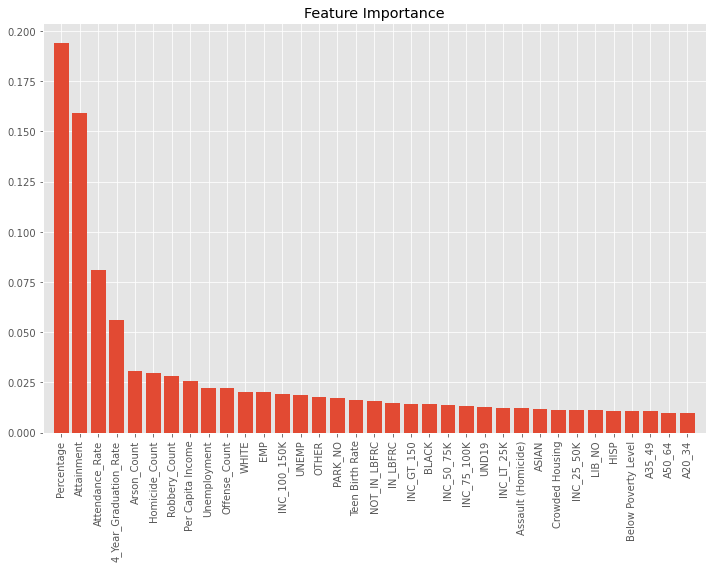

In [94]:
# Drop irrelevant columns from the dataset
X = schools.drop(['School Name', 'School_ID', 'Category', 'Year', 'Means_Composite',
                  'Numbers_Composite', 'the_geom', 'Lat', 'Long', 'Precincts', 'Community',
                  "ACT_Categorical", "Percentage_Categorical", 
                  # 'Percentage', 
                  ], axis=1)  # Dropping non-numeric and target columns

# Select the target variable
y = schools['ACT_Categorical']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Get feature importances and column names
feature_importances = rf.feature_importances_
features = X.columns

# Sort feature importances in descending order
indices = feature_importances.argsort()[::-1]

feature_list = []
# Print feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature '{features[indices[f]]}' - Importance: {feature_importances[indices[f]]}")
    feature_list.append(features[indices[f]])

# Plotting feature importance
plt.figure(figsize=(10, 8))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

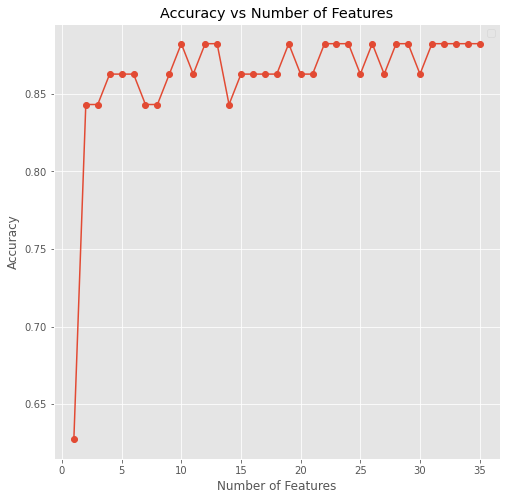

In [95]:
accuracies = []

# Split data into train and test sets
X = schools[feature_list]
y = schools['ACT_Categorical']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Iterate through feature combinations
for i in range(1, len(feature_list) + 1):
    selected_features = feature_list[:i]

    # Train the model
    model.fit(X_train[selected_features], y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test[selected_features])

    # Calculate accuracy and store in the list
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting
plt.plot(range(1, len(feature_list) + 1), accuracies, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Features')
plt.legend()
plt.show()

In [97]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif


#schools['ACT_Categorical'] = pd.cut(schools['Means_Composite'], bins=5, labels=['Very low','Low', 'Medium', 'High', 'Very high'])
#schools['ACT_Categorical'] = pd.cut(schools['Means_Composite'], bins=2, labels=['Low','High'])

X = schools.drop(['School Name', 'School_ID', 'Category', 'Year', 'Means_Composite',
                  'Numbers_Composite', 'the_geom', 'Lat', 'Long', 'Precincts', 'Community',
                  "ACT_Categorical", "Percentage_Categorical", 
                  # 'Percentage', 
                  ], axis=1)  # Dropping non-numeric and target columns

# Select the target variable
y = schools['ACT_Categorical']

# Compute mutual information scores between each feature and the categorical target
mi_scores = mutual_info_classif(X, y)

# Create a DataFrame to display feature importance scores
feature_importance = pd.DataFrame(mi_scores, index=X.columns, columns=['Importance'])
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Print all important features in order
print("Important features in order of importance:")
print(feature_importance)

features_list_mutual = feature_importance.index.tolist()

Important features in order of importance:
                        Importance
Attainment                0.704174
Percentage                0.508100
Attendance_Rate           0.273034
Teen Birth Rate           0.269791
Assault (Homicide)        0.263229
Per Capita Income         0.252119
Below Poverty Level       0.228631
Unemployment              0.221128
4_Year_Graduation_Rate    0.218676
WHITE                     0.205303
ASIAN                     0.182711
HISP                      0.180465
Crowded Housing           0.173811
BLACK                     0.171022
EMP                       0.171016
INC_GT_150                0.158596
INC_100_150K              0.146893
Homicide_Count            0.142842
IN_LBFRC                  0.131553
NOT_IN_LBFRC              0.099986
INC_LT_25K                0.098176
INC_50_75K                0.098050
A20_34                    0.096696
UND19                     0.096621
A35_49                    0.096526
UNEMP                     0.091420
INC_25_50K  

/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

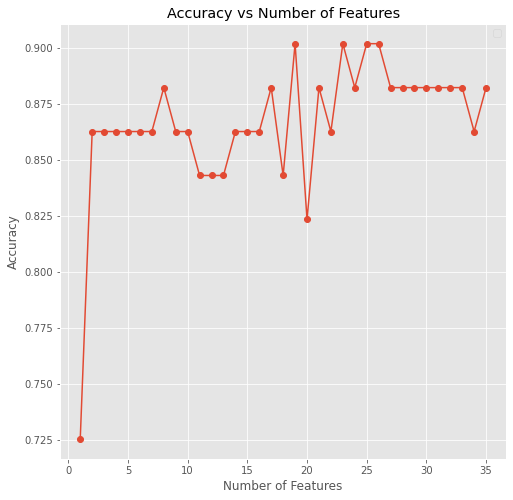

In [98]:
accuracies = []

# Split data into train and test sets
X = schools[features_list_mutual]
y = schools['ACT_Categorical']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Iterate through feature combinations
for i in range(1, len(feature_list) + 1):
    selected_features = features_list_mutual[:i]

    # Train the model
    model.fit(X_train[selected_features], y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test[selected_features])

    # Calculate accuracy and store in the list
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting
plt.plot(range(1, len(features_list_mutual) + 1), accuracies, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Features')
plt.legend()
plt.show()

In [106]:
import pandas as pd
from sklearn.feature_selection import f_classif

# Compute ANOVA F-statistic scores between each feature and the categorical target

X = schools.drop(['School Name', 'School_ID', 'Category', 'Year', 'Means_Composite',
                  'Numbers_Composite', 'the_geom', 'Lat', 'Long', 'Precincts', 'Community',
                  "ACT_Categorical", "Percentage_Categorical", 
                  # 'Percentage', 
                  ], axis=1)  # Dropping non-numeric and target columns

# Select the target variable
y = schools['ACT_Categorical']

anova_scores = f_classif(X, y)[0]

# Create a DataFrame to display feature importance scores
feature_importance = pd.DataFrame(anova_scores, index=X.columns, columns=['Fisher_Score'])
feature_importance = feature_importance.sort_values(by='Fisher_Score', ascending=False)

# Print all important features in order
print("Important features in order of Fisher's score:")
print(feature_importance)
features_list_fisher = feature_importance.index.tolist()

Important features in order of Fisher's score:
                        Fisher_Score
Percentage                239.840653
Attainment                126.979726
Attendance_Rate            48.689091
WHITE                      42.154234
4_Year_Graduation_Rate     34.710504
INC_GT_150                 31.470726
Teen Birth Rate            31.216210
Unemployment               27.810678
Homicide_Count             26.706729
EMP                        26.603528
INC_100_150K               26.272871
Assault (Homicide)         25.009128
BLACK                      24.605906
Per Capita Income          24.436292
IN_LBFRC                   23.635846
NOT_IN_LBFRC               23.578935
UNEMP                      20.733011
INC_LT_25K                 18.971084
Robbery_Count              17.259788
Arson_Count                16.509463
OTHER                      15.820027
INC_25_50K                 15.381773
Offense_Count              14.384082
INC_75_100K                14.252238
ASIAN                      1

/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

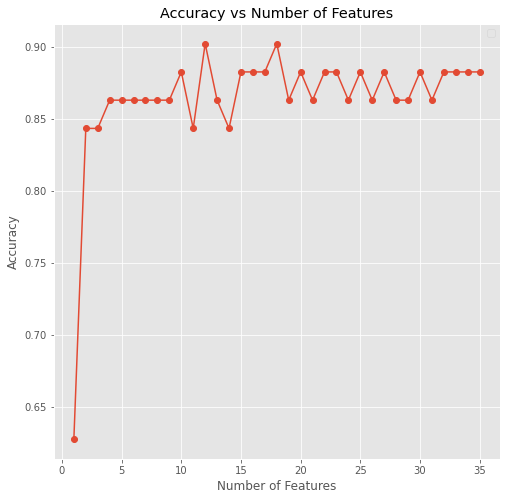

In [107]:
accuracies = []

# Split data into train and test sets
X = schools[features_list_fisher]
y = schools['ACT_Categorical']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Iterate through feature combinations
for i in range(1, len(feature_list) + 1):
    selected_features = features_list_fisher[:i]

    # Train the model
    model.fit(X_train[selected_features], y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test[selected_features])

    # Calculate accuracy and store in the list
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting
plt.plot(range(1, len(features_list_fisher) + 1), accuracies, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Features')
plt.legend()
plt.show()

In [103]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

X = schools.drop(['School Name', 'School_ID', 'Category', 'Year', 'Means_Composite',
                  'Numbers_Composite', 'the_geom', 'Lat', 'Long', 'Precincts', 'Community',
                  "ACT_Categorical", "Percentage_Categorical", 
                  # 'Percentage', 
                  ], axis=1)  # Dropping non-numeric and target columns

# Select the target variable
y = schools['ACT_Categorical']

# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a rf classifier
dt_model = RandomForestClassifier(random_state=42)

# Specify the number of features to select
num_features_to_select = 15

# Initialize SequentialFeatureSelector with 
sfs = SequentialFeatureSelector(dt_model, n_features_to_select=num_features_to_select, direction="forward")

# Fit SequentialFeatureSelector to the training data
sfs.fit(X_train, y_train)

# Transform the original features based on the selected features
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

# Train the model with the selected features
dt_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = dt_model.predict(X_test_selected)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with selected features: {accuracy:.4f}")

# Print the selected features
selected_features = X.columns[sfs.get_support()]
print("Selected features:")
print(selected_features)

/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


Accuracy with selected features: 0.8824
Selected features:
Index(['Attainment', '4_Year_Graduation_Rate', 'Attendance_Rate', 'Percentage',
       'WHITE', 'HISP', 'BLACK', 'ASIAN', 'A35_49', 'INC_GT_150',
       'Assault (Homicide)', 'Per Capita Income', 'Homicide_Count', 'PARK_NO',
       'LIB_NO'],
      dtype='object')


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

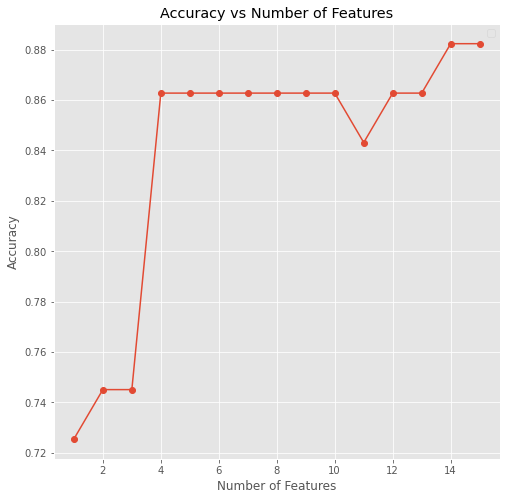

In [104]:
features_list_seq = selected_features

accuracies = []

# Split data into train and test sets
X = schools[features_list_seq]
y = schools['ACT_Categorical']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Iterate through feature combinations
for i in range(1, len(features_list_seq) + 1):
    selected_features = features_list_seq[:i]

    # Train the model
    model.fit(X_train[selected_features], y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test[selected_features])

    # Calculate accuracy and store in the list
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting
plt.plot(range(1, len(features_list_seq) + 1), accuracies, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Features')
plt.legend()
plt.show()

In [109]:
import random

def custom_feature_selection(X, y):
    features = list(X.columns)
    selected_features = []
    feature_importance = []
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize the random forest
    model = RandomForestClassifier(random_state=42)
    
    initial_feature = random.choice(features)
    selected_features.append(initial_feature)
    
    # Initial accuracy without any features
    model.fit(X_train[selected_features], y_train)
    y_pred = model.predict(X_test[selected_features])
    initial_accuracy = accuracy_score(y_test, y_pred)
    
    print(  f"Added feature initial: {initial_feature} | Initial Accuracy: {initial_accuracy:.4f}")

    # Forward Selection
    for feature in features:
        selected_features.append(feature)
        
        model.fit(X_train[selected_features], y_train)
        y_pred = model.predict(X_test[selected_features])
        new_accuracy = accuracy_score(y_test, y_pred)
        
        importance = new_accuracy - initial_accuracy
        feature_importance.append((feature, importance))
        
        if new_accuracy > initial_accuracy:
            print(f"Added feature later: {feature} | New Accuracy: {new_accuracy:.4f}")
            initial_accuracy = new_accuracy
        else:
            # Remove the last added feature if accuracy decreases
            
            selected_features.pop()
    
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    sorted_features = [feature[0] for feature in feature_importance]
    print(sorted_features)
    return feature_importance, sorted_features

X = schools.drop(['School Name', 'School_ID', 'Category', 'Year', 'Means_Composite',
                  'Numbers_Composite', 'the_geom', 'Lat', 'Long', 'Precincts', 'Community',
                  "ACT_Categorical", "Percentage_Categorical", 
                  # 'Percentage', 
                  ], axis=1)  # Dropping non-numeric and target columns

# Select the target variable
y = schools['ACT_Categorical']

feature_importance_custom, selected_features_custom = custom_feature_selection(X, y)

/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: INC_25_50K | Initial Accuracy: 0.4902
Added feature later: Attainment | New Accuracy: 0.7059
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7451


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8431


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: UND19 | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

['Attainment', 'Percentage', '4_Year_Graduation_Rate', 'UND19', 'WHITE', 'HISP', 'BLACK', 'ASIAN', 'OTHER', 'A20_34', 'A50_64', 'EMP', 'UNEMP', 'INC_100_150K', 'Teen Birth Rate', 'Assault (Homicide)', 'Crowded Housing', 'Unemployment', 'Arson_Count', 'Homicide_Count', 'PARK_NO', 'LIB_NO', 'A35_49', 'IN_LBFRC', 'NOT_IN_LBFRC', 'INC_LT_25K', 'INC_25_50K', 'INC_50_75K', 'INC_75_100K', 'INC_GT_150', 'Below Poverty Level', 'Per Capita Income', 'Robbery_Count', 'Offense_Count', 'Attendance_Rate']


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def custom_feature_selection(X, y):
    features = list(X.columns)
    selected_features = []
    feature_importance = []

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the random forest
    model = RandomForestClassifier(random_state=42)

    # Iterate over each feature
    for feature in features:
        # Initialize selected features with the current feature
        selected_features = [feature]

        # Initial accuracy with only the current feature
        model.fit(X_train[selected_features], y_train)
        y_pred = model.predict(X_test[selected_features])
        initial_accuracy = accuracy_score(y_test, y_pred)

        print(f"Added feature initial: {feature} | Initial Accuracy: {initial_accuracy:.4f}")

        # Forward Selection
        for other_feature in features:
            if other_feature != feature:
                selected_features.append(other_feature)

                model.fit(X_train[selected_features], y_train)
                y_pred = model.predict(X_test[selected_features])
                new_accuracy = accuracy_score(y_test, y_pred)

                importance = new_accuracy - initial_accuracy
                feature_importance.append((feature, other_feature, importance))

                if new_accuracy > initial_accuracy:
                    print(f"Added feature later: {other_feature} | New Accuracy: {new_accuracy:.4f}")
                    initial_accuracy = new_accuracy
                else:
                    # Remove the last added feature if accuracy decreases
                    selected_features.pop()

    feature_importance.sort(key=lambda x: x[2], reverse=True)
    sorted_features = [feature[1] for feature in feature_importance]
    print(sorted_features)
    return feature_importance, sorted_features

# Assuming X and y are already defined
feature_importance_custom, selected_features_custom = custom_feature_selection(X, y)


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: Attainment | Initial Accuracy: 0.7255
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7451
Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: UNEMP | New Accuracy: 0.8824


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Unemployment | New Accuracy: 0.9020


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: 4_Year_Graduation_Rate | Initial Accuracy: 0.4118
Added feature later: Attainment | New Accuracy: 0.7647
Added feature later: Percentage | New Accuracy: 0.8431


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: WHITE | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: Attendance_Rate | Initial Accuracy: 0.5294
Added feature later: Attainment | New Accuracy: 0.7059
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7451
Added feature later: Percentage | New Accuracy: 0.8431


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: WHITE | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: Percentage | Initial Accuracy: 0.6275
Added feature later: Attainment | New Accuracy: 0.8431
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: WHITE | Initial Accuracy: 0.5294
Added feature later: Attainment | New Accuracy: 0.7255
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7647


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: HISP | Initial Accuracy: 0.5294
Added feature later: Attainment | New Accuracy: 0.7255
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7647


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8431


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: BLACK | Initial Accuracy: 0.5098
Added feature later: Attainment | New Accuracy: 0.7255
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7843


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: ASIAN | Initial Accuracy: 0.5490
Added feature later: Attainment | New Accuracy: 0.7255
Added feature later: Attendance_Rate | New Accuracy: 0.7451


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: OTHER | Initial Accuracy: 0.4902
Added feature later: Attainment | New Accuracy: 0.7255
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7647


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: UND19 | Initial Accuracy: 0.4902
Added feature later: Attainment | New Accuracy: 0.7451
Added feature later: Attendance_Rate | New Accuracy: 0.7647


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: A20_34 | Initial Accuracy: 0.5098
Added feature later: Attainment | New Accuracy: 0.7451
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7647


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: A35_49 | Initial Accuracy: 0.4314
Added feature later: Attainment | New Accuracy: 0.6863
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7059
Added feature later: Attendance_Rate | New Accuracy: 0.7255


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: UNEMP | New Accuracy: 0.8824
Added feature later: INC_25_50K | New Accuracy: 0.9020


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: A50_64 | Initial Accuracy: 0.4314
Added feature later: Attainment | New Accuracy: 0.6863


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8431


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: ASIAN | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: IN_LBFRC | Initial Accuracy: 0.4902
Added feature later: Attainment | New Accuracy: 0.7255
Added feature later: Attendance_Rate | New Accuracy: 0.7451


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: EMP | Initial Accuracy: 0.5294
Added feature later: Attainment | New Accuracy: 0.7451
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7843
Added feature later: Attendance_Rate | New Accuracy: 0.8039


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: UNEMP | Initial Accuracy: 0.5098
Added feature later: Attainment | New Accuracy: 0.7059
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7255


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: A35_49 | New Accuracy: 0.8824
Added feature later: A50_64 | New Accuracy: 0.9020


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: NOT_IN_LBFRC | Initial Accuracy: 0.4902
Added feature later: Attainment | New Accuracy: 0.7255
Added feature later: Attendance_Rate | New Accuracy: 0.7451


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: INC_LT_25K | Initial Accuracy: 0.4706
Added feature later: Attainment | New Accuracy: 0.7647


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8431


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Robbery_Count | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: INC_25_50K | Initial Accuracy: 0.4902
Added feature later: Attainment | New Accuracy: 0.7059
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7451


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8431


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: UND19 | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: INC_50_75K | Initial Accuracy: 0.4510
Added feature later: Attainment | New Accuracy: 0.6863
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7255


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8431


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: UNEMP | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: INC_75_100K | Initial Accuracy: 0.4706
Added feature later: Attainment | New Accuracy: 0.7255


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8431


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: A50_64 | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: INC_100_150K | Initial Accuracy: 0.5098
Added feature later: Attainment | New Accuracy: 0.8039


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8431


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Robbery_Count | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: INC_GT_150 | Initial Accuracy: 0.5098
Added feature later: Attainment | New Accuracy: 0.7647
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7843


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: A35_49 | New Accuracy: 0.8824
Added feature later: EMP | New Accuracy: 0.9020


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: UNEMP | New Accuracy: 0.9216


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: Teen Birth Rate | Initial Accuracy: 0.6078
Added feature later: Attainment | New Accuracy: 0.7843
Added feature later: Attendance_Rate | New Accuracy: 0.8039


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: Assault (Homicide) | Initial Accuracy: 0.5686
Added feature later: Attainment | New Accuracy: 0.7647
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7843


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: A35_49 | New Accuracy: 0.8824
Added feature later: EMP | New Accuracy: 0.9020


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: Below Poverty Level | Initial Accuracy: 0.6275
Added feature later: Attainment | New Accuracy: 0.7451


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: Crowded Housing | Initial Accuracy: 0.5686
Added feature later: Attainment | New Accuracy: 0.8039
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.8431
Added feature later: Attendance_Rate | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: Per Capita Income | Initial Accuracy: 0.5686
Added feature later: Attainment | New Accuracy: 0.7647
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7843
Added feature later: Attendance_Rate | New Accuracy: 0.8235


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: Unemployment | Initial Accuracy: 0.5686
Added feature later: Attainment | New Accuracy: 0.8235
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: PARK_NO | New Accuracy: 0.9216
Added feature initial: Robbery_Count | Initial Accuracy: 0.3333
Added feature later: Attainment | New Accuracy: 0.7059


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Attendance_Rate | New Accuracy: 0.7255
Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: A35_49 | New Accuracy: 0.8824


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: UNEMP | New Accuracy: 0.9020


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: PARK_NO | New Accuracy: 0.9216
Added feature initial: Arson_Count | Initial Accuracy: 0.3922
Added feature later: Attainment | New Accuracy: 0.6078


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.6275
Added feature later: Attendance_Rate | New Accuracy: 0.6863
Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: UNEMP | New Accuracy: 0.8824


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Unemployment | New Accuracy: 0.9020


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: Homicide_Count | Initial Accuracy: 0.4314
Added feature later: Attainment | New Accuracy: 0.7255


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8431
Added feature later: WHITE | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: Offense_Count | Initial Accuracy: 0.4706
Added feature later: Attainment | New Accuracy: 0.7647
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.7843
Added feature later: Attendance_Rate | New Accuracy: 0.8039


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: PARK_NO | Initial Accuracy: 0.4706
Added feature later: Attainment | New Accuracy: 0.8039
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.8235


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature initial: LIB_NO | Initial Accuracy: 0.4314
Added feature later: Attainment | New Accuracy: 0.6471
Added feature later: 4_Year_Graduation_Rate | New Accuracy: 0.6667
Added feature later: Attendance_Rate | New Accuracy: 0.6863


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

Added feature later: Percentage | New Accuracy: 0.8627


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

['Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Attainment', 'Percentage', 'Percentage', 'Attainment', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Attainment', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Percentage', 'Percentage', '4_Year_Graduation_Rate', 'Percentage', 'Percentage', 'Attendance_Rate', 'Percentage', 'PARK_NO', 'Percentage', '4_Year_Graduation_Rate', 'Percentage', '4_Year

/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [112]:
features_star = ['Unemployment', 'Attainment',  '4_Year_Graduation_Rate','PARK_NO','Percentage', 'Attendance_Rate', 'WHITE', 'HISP', 'BLACK', 
                 'ASIAN', 'OTHER', 'UND19', 'A20_34', 'A35_49', 'A50_64', 'IN_LBFRC', 'EMP', 'UNEMP', 'NOT_IN_LBFRC', 
                 'INC_LT_25K', 'INC_25_50K', 'INC_50_75K', 'INC_75_100K', 'INC_100_150K', 'INC_GT_150', 'Teen Birth Rate',
                 'Assault (Homicide)', 'Below Poverty Level', 'Crowded Housing', 'Per Capita Income', 
                 'Robbery_Count', 'Arson_Count', 'Homicide_Count', 'Offense_Count',  'LIB_NO',]

/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

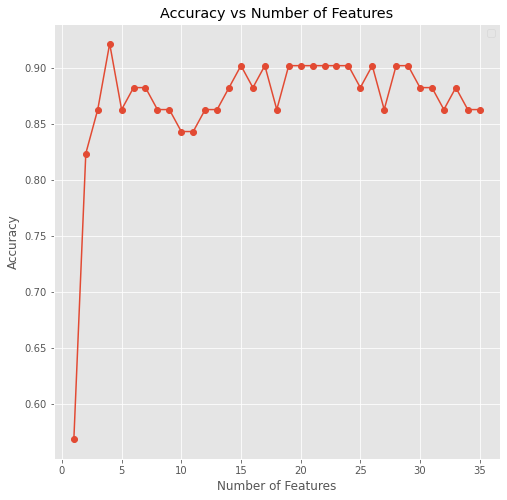

In [113]:
accuracies = []

# Split data into train and test sets
X = schools[features_star]
y = schools['ACT_Categorical']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

selected_features = features_star

# Iterate through feature combinations
for i in range(1, len(features_star) + 1):
    selected_features = features_star[:i]

    # Train the model
    model.fit(X_train[selected_features], y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test[selected_features])

    # Calculate accuracy and store in the list
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting
plt.plot(range(1, len(features_star) + 1), accuracies, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Features')
plt.legend()
plt.show()

In [114]:
accuracies

[0.5686274509803921,
 0.8235294117647058,
 0.8627450980392157,
 0.9215686274509803,
 0.8627450980392157,
 0.8823529411764706,
 0.8823529411764706,
 0.8627450980392157,
 0.8627450980392157,
 0.8431372549019608,
 0.8431372549019608,
 0.8627450980392157,
 0.8627450980392157,
 0.8823529411764706,
 0.9019607843137255,
 0.8823529411764706,
 0.9019607843137255,
 0.8627450980392157,
 0.9019607843137255,
 0.9019607843137255,
 0.9019607843137255,
 0.9019607843137255,
 0.9019607843137255,
 0.9019607843137255,
 0.8823529411764706,
 0.9019607843137255,
 0.8627450980392157,
 0.9019607843137255,
 0.9019607843137255,
 0.8823529411764706,
 0.8823529411764706,
 0.8627450980392157,
 0.8823529411764706,
 0.8627450980392157,
 0.8627450980392157]

In [115]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import BernoulliNB
    
from sklearn.model_selection import cross_val_score
import numpy as np

# This function calculates feature importance scores for a given dataset using an inverse approach with Naive Bayes classifier.
# It iteratively removes each feature, retrains the classifier, and measures the change in performance to determine importance.

def inverse_naive_bayes_feature_importance(X, y):
    # Choose the Naive Bayes classifier (MultinomialNB, GaussianNB, or ComplementNB)
    nb_classifier = MultinomialNB()
    #nb_classifier = GaussianNB()
    #nb_classifier = ComplementNB() 
    
    # Calculate the baseline score using cross-validation
    baseline_score = np.mean(cross_val_score(nb_classifier, X, y, cv=5))

    # Step 2: Iterate over features
    feature_importance_scores = []
    for feature in X.columns:
        # Step 3: Remove, re-train, measure, and calculate importance score
        X_without_feature = X.drop(columns=[feature])
        new_score = np.mean(cross_val_score(nb_classifier, X_without_feature, y, cv=5))
        importance_score = baseline_score - new_score

        # Store feature importance scores
        feature_importance_scores.append((feature, importance_score))

    # Rank features based on importance scores in descending order
    ranked_features = sorted(feature_importance_scores, key=lambda x: x[1], reverse=True)
    
    # Extract only the feature names
    features_only = [feature[0] for feature in ranked_features]
    
    return features_only

# Apply the function to training data
selected_features = inverse_naive_bayes_feature_importance(X_train, y_train)
print(selected_features)

/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

['Attendance_Rate', 'HISP', 'Offense_Count', 'Teen Birth Rate', 'Attainment', 'Crowded Housing', 'LIB_NO', 'Unemployment', '4_Year_Graduation_Rate', 'Percentage', 'WHITE', 'BLACK', 'ASIAN', 'OTHER', 'UND19', 'A20_34', 'A35_49', 'A50_64', 'IN_LBFRC', 'EMP', 'UNEMP', 'NOT_IN_LBFRC', 'INC_LT_25K', 'INC_25_50K', 'INC_50_75K', 'INC_75_100K', 'INC_100_150K', 'INC_GT_150', 'Robbery_Count', 'Arson_Count', 'PARK_NO', 'Below Poverty Level', 'Homicide_Count', 'Assault (Homicide)', 'Per Capita Income']


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and wil

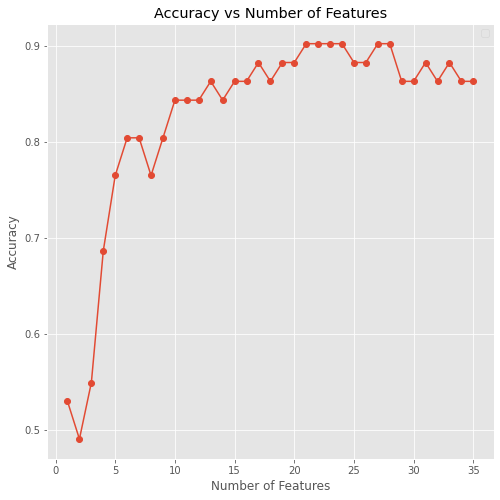

In [116]:
accuracies = []

# Split data into train and test sets
features_only = selected_features
X = schools[features_only]
y = schools['ACT_Categorical']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

selected_features = features_only

# Iterate through feature combinations
for i in range(1, len(features_only) + 1):
    selected_features = features_only[:i]

    # Train the model
    model.fit(X_train[selected_features], y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test[selected_features])

    # Calculate accuracy and store in the list
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting
plt.plot(range(1, len(features_only) + 1), accuracies, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Features')
plt.legend()
plt.show()

In [117]:
accuracies

[0.5294117647058824,
 0.49019607843137253,
 0.5490196078431373,
 0.6862745098039216,
 0.7647058823529411,
 0.803921568627451,
 0.803921568627451,
 0.7647058823529411,
 0.803921568627451,
 0.8431372549019608,
 0.8431372549019608,
 0.8431372549019608,
 0.8627450980392157,
 0.8431372549019608,
 0.8627450980392157,
 0.8627450980392157,
 0.8823529411764706,
 0.8627450980392157,
 0.8823529411764706,
 0.8823529411764706,
 0.9019607843137255,
 0.9019607843137255,
 0.9019607843137255,
 0.9019607843137255,
 0.8823529411764706,
 0.8823529411764706,
 0.9019607843137255,
 0.9019607843137255,
 0.8627450980392157,
 0.8627450980392157,
 0.8823529411764706,
 0.8627450980392157,
 0.8823529411764706,
 0.8627450980392157,
 0.8627450980392157]

In [118]:
X = schools[['Percentage', 'Attainment' , 'Attendance_Rate', 'Robbery_Count', '4_Year_Graduation_Rate' ]] #rf 

#X = schools[["Percentage", "Attainment", "Per Capita Income", "Assault (Homicide)", "Teen Birth Rate", ]] #mutual info


#X = schools[["Percentage","Attainment","Attendance_Rate","WHITE","4_Year_Graduation_Rate", "INC_GT_150","Teen Birth Rate"]] #fishers score


#X = schools[["Attendance_Rate", "HISP", "Offense_Count", "Teen Birth Rate", "Attainment", "Crowded Housing",
             #"LIB_NO"]] #MultinomialNB


X = schools[["Unemployment", "Attainment","4_Year_Graduation_Rate", "PARK_NO"]] #star

#X = schools[['Attainment', 'Percentage', 'WHITE', 'ASIAN', 'LIB_NO']] #seq. feature selector



y = schools['ACT_Categorical']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#model_original = GaussianNB()
model_original = RandomForestClassifier(n_estimators=100, random_state=42)

model_original.fit(X_train, y_train)

y_pred_original = model_original.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_original)
f1 = f1_score(y_test, y_pred_original, average='weighted')  # 'weighted' is just an example, you can choose other options

print(f"Accuracy of the classifier: {accuracy:.4f}")
print(f"F1 score of the classifier: {f1:.4f}")


Accuracy of the classifier: 0.9216
F1 score of the classifier: 0.9218


/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/melike/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [ ]:
## Feature Engineering starts

schools_feature = schools

In [ ]:
# Define a list of race columns in the dataset
race_columns = ['WHITE', 'HISP', 'BLACK', 'ASIAN', 'OTHER']

# Define a function to find the predominant race for each row in the dataset
def find_predominant_race(row):
    # Extract race counts for each race column in the current row
    race_counts = [row[race] for race in race_columns]
    
    # Find the maximum count of races
    max_count = max(race_counts)
    
    # Find the index of the maximum count, representing the predominant race
    max_race_index = race_counts.index(max_count)
    
    # Return the name of the predominant race based on the index
    return race_columns[max_race_index]

# Apply the 'find_predominant_race' function to each row in the 'schools_feature' DataFrame
schools_feature['Predominant_Race'] = schools_feature.apply(find_predominant_race, axis=1)

In [ ]:
race_counts = schools_feature['Predominant_Race'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
race_counts.plot(kind='bar', color='skyblue')
plt.title('Counts of Different Races')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-labels for better readability if needed
plt.tight_layout()
plt.show()

In [ ]:
# Function to check if the unemployment value in a row is greater than 0.05
def check_unemployment(row):
    # Check if the value in the 'UNEMP' column of the row is greater than 0.05
    if row['UNEMP'] > 0.05:
        return "Y"
    else:
        return "N"

# Apply the check_unemployment function to each row of the 'schools_feature' DataFrame along axis 1
schools_feature['highunemploymentYN'] = schools_feature.apply(check_unemployment, axis=1)


In [ ]:
race_counts = schools_feature['highunemploymentYN'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
race_counts.plot(kind='bar', color='skyblue')
plt.title('Counts of highunemploymentYN')
plt.xlabel('Unemployed')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-labels for better readability if needed
plt.tight_layout()
plt.show()

In [ ]:
schools_feature.columns

In [ ]:
# Drop unnecessary columns from the 'schools_feature' dataframe
columns_to_drop = ['School Name', 'Category', 'Year', 'Means_Composite',
                   'Numbers_Composite', 'the_geom', 'Lat', 'Long', 
                   'Precincts', 'Community']
schools_feature = schools_feature.drop(columns=columns_to_drop)

# Define a list of columns to apply binning to
columns_to_bin = ['Percentage', 'Attainment', '4_Year_Graduation_Rate', 'Attendance_Rate',
                  'EMP', 'Teen Birth Rate', 'Assault (Homicide)', 'Below Poverty Level', 
                  'Crowded Housing', 'Per Capita Income', 'Unemployment', 'Robbery_Count',
                  'Arson_Count', 'Homicide_Count', 'Offense_Count', 'PARK_NO', 'LIB_NO']

# Define a function to create bins for a given column
def create_bins(column):
    column_numeric = pd.to_numeric(column, errors='coerce')
    if column_numeric.isnull().values.any():
        column_numeric.fillna(column_numeric.mean(), inplace=True)
    
    # Create bins for the numeric column
    bins = np.linspace(min(column_numeric), max(column_numeric), num_bins + 1)
    return pd.cut(column_numeric, bins, labels=False, include_lowest=True)

# Apply binning to specified columns and create new columns with '_bin' suffix
num_bins = 5  # Number of bins
for column in columns_to_bin:
    schools_feature[column + '_bin'] = create_bins(schools_feature[column])

# Display the updated dataframe with new bin columns
schools_feature

In [ ]:
columns_to_drop = [
    'Attainment', '4_Year_Graduation_Rate', 'Attendance_Rate', 'Percentage',
    'WHITE', 'HISP', 'BLACK', 'ASIAN', 'OTHER', 'UND19', 'A20_34',
    'A35_49', 'A50_64', 'IN_LBFRC', 'EMP', 'UNEMP', 'NOT_IN_LBFRC', 'INC_LT_25K',
    'INC_25_50K', 'INC_50_75K', 'INC_75_100K', 'INC_100_150K', 'INC_GT_150',
    'Teen Birth Rate', 'Assault (Homicide)', 'Below Poverty Level', 'Crowded Housing',
    'Per Capita Income', 'Unemployment', 'Robbery_Count', 'Arson_Count', 'Homicide_Count',
    'Offense_Count', 'PARK_NO', "LIB_NO"
]

# Drop specified columns
schools_bin = schools_feature.drop(columns=columns_to_drop, inplace=True)


In [ ]:
#schools.drop(columns=['School_ID'], inplace=True)

# Perform one-hot encoding for 'Predominant_Race' column
schools_bin = pd.get_dummies(schools_feature, drop_first=True, columns=['Predominant_Race'])

In [ ]:
schools_bin['Predominant_Race_BLACK'] = schools_bin['Predominant_Race_BLACK'].astype(int)
schools_bin['Predominant_Race_HISP'] = schools_bin['Predominant_Race_HISP'].astype(int)
schools_bin['Predominant_Race_WHITE'] = schools_bin['Predominant_Race_WHITE'].astype(int)

In [ ]:
from sklearn.preprocessing import LabelEncoder
column_to_encode = 'highunemploymentYN'

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the chosen column
schools_bin[column_to_encode] = label_encoder.fit_transform(schools_bin[column_to_encode])



In [ ]:
#schools_bin["Percentage_Categorical"] = label_encoder.fit_transform(schools_bin["Percentage_Categorical"])

In [ ]:
schools_bin.head(5)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

X = schools_bin.drop(columns=['ACT_Categorical', "School_ID", "Percentage_Categorical",])
y = schools_bin['ACT_Categorical']

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X, y)

feature_importances = rf_classifier.feature_importances_

indices = feature_importances.argsort()[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature '{X.columns[indices[f]]}' ({feature_importances[indices[f]]})")

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()


In [ ]:
ranked_features = inverse_naive_bayes_feature_importance(X, y)

print(ranked_features)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


X = schools_bin.drop(columns=['ACT_Categorical', "School_ID", "Percentage_Categorical",])
 
y = schools_bin['ACT_Categorical']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)


y_pred = rf_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted') 

print(f"Accuracy of the classifier: {accuracy:.2f}")
print(f"F1 score of the classifier: {f1:.2f}")

In [ ]:
## Cluster Score Starts

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting relevant safety features from the 'schools' DataFrame
#safety_features = schools[['Robbery_Count', 'Arson_Count', 'Homicide_Count', 'Offense_Count', 'Assault (Homicide)']]
safety_features = schools_bin[['Robbery_Count_bin', 'Arson_Count_bin', 'Homicide_Count_bin', 'Offense_Count_bin', 
                           'Assault (Homicide)_bin']]

# Standardizing the selected safety features using StandardScaler
scaler = StandardScaler()
safety_features_normalized = scaler.fit_transform(safety_features)

# Initialize an empty list to store the Within-Cluster-Sum-of-Squares (WCSS) for different cluster numbers
wcss = []

# Iterate through a range of cluster numbers (1 to 10) to find the optimal number of clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(safety_features_normalized)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph to visually identify the optimal number of clusters
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

# Based on the Elbow Method, it seems like the optimal number of clusters is 3
# Perform k-means clustering with 3 clusters and assign the cluster labels to the 'safety_cluster' column
safety_kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
schools_bin['safety_cluster'] = safety_kmeans.fit_predict(safety_features_normalized)


In [ ]:
# Extract relevant social features from the 'schools' DataFrame
#social_features = schools[['PARK_NO',  'LIB_NO']]
social_features = schools_bin[['PARK_NO_bin',  'LIB_NO_bin']]

# Standardize the social features using StandardScaler
scaler = StandardScaler()
social_features_normalized = scaler.fit_transform(social_features)

# Initialize a list to store the within-cluster sum of squares (WCSS) for different numbers of clusters
wcss = []

# Iterate over a range of cluster numbers to find the optimal number of clusters using the elbow method
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(social_features_normalized)
    wcss.append(kmeans.inertia_)

# Plot the elbow method to visualize the optimal number of clusters
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

# Apply k-means clustering with the chosen number of clusters (4 in this case)
social_kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Add a new column 'social_cluster' to the 'schools' DataFrame representing the cluster assignment for each school
schools_bin['social_cluster'] = social_kmeans.fit_predict(social_features_normalized)

In [ ]:
schools_bin.columns

In [ ]:
# 'highunemploymentYN',   'EMP_bin', 'Teen Birth Rate_bin', 'Below Poverty Level_bin',  'Crowded Housing_bin', 
# 'Per Capita Income_bin', 'Unemployment_bin',  'Predominant_Race_BLACK', 'Predominant_Race_HISP',  'Predominant_Race_WHITE',

# Extracting relevant features from the 'schools' DataFrame

#region_features = schools[['WHITE', 'HISP', 'BLACK', 'ASIAN', 'OTHER', 'UND19', 'A20_34', 'A35_49',
#       'A50_64', 'IN_LBFRC', 'EMP', 'UNEMP', 'NOT_IN_LBFRC', 'INC_LT_25K',
#       'INC_25_50K', 'INC_50_75K', 'INC_75_100K', 'INC_100_150K', 'INC_GT_150',
#       'Teen Birth Rate','Below Poverty Level',
#       'Crowded Housing', 'Per Capita Income', 'Unemployment', ]]

region_features = schools_bin[['Predominant_Race_WHITE', 'Predominant_Race_HISP', 'Predominant_Race_BLACK',
                               #'Predominant_Race_ASIAN', 'OTHER', 'UND19', 'A20_34', 'A35_49', 'A50_64', 'IN_LBFRC',
                               # 'UNEMP', 'NOT_IN_LBFRC', 'INC_LT_25K',
       #'INC_25_50K', 'INC_50_75K', 'INC_75_100K', 'INC_100_150K', 'INC_GT_150',
                               'EMP_bin', 'Teen Birth Rate_bin', 'Unemployment_bin', 'Below Poverty Level_bin',
                               'Crowded Housing_bin', 'Per Capita Income_bin', "highunemploymentYN" ]]


# Standardize the features using StandardScaler
scaler = StandardScaler()
region_features_normalized = scaler.fit_transform(region_features)

# Initialize an empty list to store the within-cluster sum of squares (WCSS) for different cluster sizes
wcss = []

# Perform K-means clustering for different cluster sizes (1 to 10)
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(region_features_normalized)
    wcss.append(kmeans.inertia_)

# Plot the elbow method to determine the optimal number of clusters
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

# Based on the elbow method plot, it seems the optimal number of clusters is chosen as 3

# Perform K-means clustering with the optimal number of clusters (3)
region_kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
# Assign cluster labels to the 'schools' DataFrame
schools_bin['region_cluster'] = region_kmeans.fit_predict(region_features_normalized)

In [ ]:
#'ACT_Categorical', 'Percentage_Categorical', 'Attainment_bin', '4_Year_Graduation_Rate_bin', 'Attendance_Rate_bin',

# Extract relevant features from the 'schools' DataFrame
#school_features = schools[["Percentage", 'Attainment', '4_Year_Graduation_Rate', 'Attendance_Rate']]
school_features = schools_bin[["Percentage_bin", 'Attainment_bin', '4_Year_Graduation_Rate_bin', 'Attendance_Rate_bin']]



# Standardize the features using StandardScaler
scaler = StandardScaler()
school_features_normalized = scaler.fit_transform(school_features)

# Initialize an empty list to store the Within-Cluster-Sum-of-Squares (WCSS) for different cluster numbers
wcss = []

# Iterate over a range of cluster numbers to determine the optimal number of clusters using the Elbow Method
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(school_features_normalized)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method to visualize the optimal number of clusters
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

# Perform KMeans clustering with the chosen number of clusters (4 in this case)
school_kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)

# Assign cluster labels to the 'school_cluster' column in the 'schools' DataFrame
schools_bin['school_cluster'] = school_kmeans.fit_predict(school_features_normalized)

In [ ]:
schools.columns

In [ ]:

target_column = 'ACT_Categorical'

#X = schools[["school_cluster", "region_cluster",  "safety_cluster",  "social_cluster" ]]
X = schools_bin[["school_cluster", "region_cluster",  "safety_cluster",  "social_cluster" ]]

y = schools[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#model_original = DecisionTreeClassifier()
 
#model_original = MLPClassifier(hidden_layer_sizes=(40,), max_iter=500, random_state=42)
model_original = RandomForestClassifier(n_estimators=100, random_state=42)

model_original.fit(X_train, y_train)

y_pred_original = model_original.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_original)
f1 = f1_score(y_test, y_pred_original, average='weighted')  # 'weighted' is just an example, you can choose other options

print(f"Accuracy of the classifier: {accuracy:.4f}")
print(f"F1 score of the classifier: {f1:.4f}")


In [ ]:
ranked_features = inverse_naive_bayes_feature_importance(X_train, y_train)

print(ranked_features)

In [ ]:

selected_features = custom_feature_selection(X, y)